# Demo 10 : Decision 🌳s 

In this demo, you will implement:
- training a decision tree
- different methods for training a random forest


## Prepare the data

We will use the Iris dataset again. Start by loading the data and splitting it into train/test sets.

In [103]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets

iris = datasets.load_iris()

# Split into train/test
from sklearn.model_selection import train_test_split

(iris_train_x, iris_test_x, 
 iris_train_y, iris_test_y) = train_test_split(iris.data, iris.target, test_size=100)

print(iris_train_x.shape)
print(iris_test_x.shape)

(50, 4)
(100, 4)


## Decision tree

To implement the basic decision tree, we will first implement some helper functions.

In [107]:
from collections import Counter

def get_majority_class(labels):
    counts = Counter(labels)
    return counts.most_common(1)[0][0]

def compute_entropy(labels):
    counts = Counter(labels)
    counts = np.array([counts[key] for key in counts])
    frequencies = counts/counts.sum()
    entropy = -(frequencies * np.log2(frequencies)).sum()
    return entropy

example_labels = np.array([3,1,2,0,2])
print(get_majority_class(example_labels)) # should be 2
print(compute_entropy(example_labels)) # should be 1.9219280948873623

2
1.9219280948873623


Let's write a **Node** class to use in the decision tree. A node in the tree can:
- ask a question,
- find the best question to split a (subset of a) dataset, or
- if it is a leaf node, predict an output.

In [108]:
class Node():
    def __init__(self):
        self.threshold = None
        self.col = None
        self.is_leaf = None
        self.output_class = None
        
    def find_best_question(self, x, y):
        best_col = None
        best_val = None
        best_loss = np.inf
        
        num_cols = x.shape[1]
        valid_cols = np.arange(num_cols)
        for col in valid_cols:
            sorted_indices = x[:, col].argsort()
            sorted_vals = x[sorted_indices, col]
            midpoints = [(sorted_vals[i] + sorted_vals[i+1])/2 for i in range(len(sorted_vals)-1) ]
            for val in midpoints:
                right_subset_rows = x[:, col] > val 
                left_subset_rows = np.invert(right_subset_rows)
                right_labels = y[right_subset_rows]
                left_labels = y[left_subset_rows]
                
                right_entropy = compute_entropy(right_labels)
                left_entropy = compute_entropy(left_labels)
                loss = left_entropy + right_entropy
                if right_labels.shape[0] == 0 or left_labels.shape[0] == 0:
                    continue
                
                if loss < best_loss:
                    best_loss = loss
                    best_col = col
                    best_val = val
                    
        self.col = best_col
        self.threshold = best_val
    
    def ask_question(self, x):
        if not self.is_leaf:
            return x[:, self.col] > self.threshold
        else:
            print("Error: leaf nodes cannot ask questions!")
            return False
    
    def predict(self):
        if self.is_leaf:
            return self.output_class
        else:
            print("Error: non-leaf nodes cannot make a prediction!")
            return None

Now, using the Node class, we will implement the decision tree. Like scikit-learn's interface, we will have fit() and predict() methods.

In [109]:
class DecisionTreeClassifier():
    def __init__(self, max_depth=1):
        self.max_depth = max_depth
    
    def create_node(self, x_subset, y_subset, depth):
        # Recursive function
        node = Node()
        
        majority_class = get_majority_class(y_subset)
        majority_class_count = (y_subset == majority_class).sum()
        perfectly_classified = majority_class_count == len(y_subset)
        
        if perfectly_classified or depth == self.max_depth:
            node.output_class = majority_class
            node.is_leaf = True
        else:
            node.find_best_question(x_subset,y_subset)
            node.is_leaf = False
            right_subset_rows = node.ask_question(x_subset) 
            left_subset_rows = np.invert(right_subset_rows)
            node.left_child = self.create_node(x_subset[left_subset_rows], y_subset[left_subset_rows],  depth+1)
            node.right_child = self.create_node(x_subset[right_subset_rows], y_subset[right_subset_rows], depth+1)
                
        return node
    
    def fit(self, x, y):
        self.root_node = self.create_node(x,y,depth=1)
    
    def predict(self, x):
        predictions = []
        
        for i in range(len(x)):
            current_node = self.root_node
            x_i = x[i].reshape(1,-1)
            done_descending_tree = False
            while not done_descending_tree:
                if current_node.is_leaf:
                    predictions.append(current_node.predict())
                    done_descending_tree = True

                else:
                    if current_node.ask_question(x_i):
                        current_node = current_node.right_child
                    else:
                        current_node = current_node.left_child

        return np.array(predictions)
        

Train a tree to test your implementation. (You can also try comparing with scikit-learn's tree implementation.)

In [110]:
# import sklearn.tree
# tree = sklearn.tree.DecisionTreeClassifier(max_depth=10)
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(iris_train_x, iris_train_y)
print(iris_test_y)
print(tree.predict(iris_test_x))
print("accuracy: ", (tree.predict(iris_test_x) == iris_test_y).mean() * 100, "%")

[1 0 1 2 0 2 2 1 0 0 2 2 2 0 2 0 0 2 1 2 0 2 2 0 0 1 1 0 0 2 2 1 2 1 0 1 0
 1 1 1 1 2 1 1 1 1 0 1 2 1 1 0 1 0 1 2 0 2 1 1 1 1 1 2 1 0 0 2 1 1 2 0 2 0
 0 0 0 2 0 0 1 1 2 0 2 1 0 1 0 1 0 0 1 0 2 0 2 1 2 0]
[1 0 1 2 0 2 2 1 0 0 2 2 2 0 1 0 0 2 1 2 0 2 2 0 0 1 1 0 0 2 2 1 2 1 0 1 0
 1 1 1 1 2 2 1 1 1 0 1 2 2 1 0 1 0 1 2 0 2 1 1 1 1 1 2 1 0 0 2 1 1 2 0 2 0
 0 0 0 2 0 0 1 1 2 0 1 1 0 1 0 1 0 0 1 0 2 0 2 1 2 0]
accuracy:  96.0 %


Train trees of increasing depth on the Iris dataset and plot their performance. What do you notice about the performance as the depth increases?

Best performance:  0.96


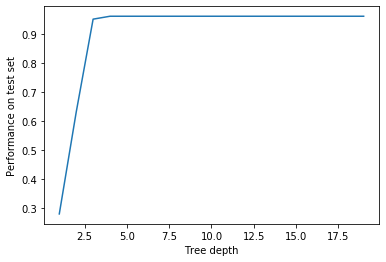

In [111]:
depths = []
accuracies = []
for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(iris_train_x, iris_train_y)
    accuracy = (model.predict(iris_test_x) == iris_test_y).mean()
    accuracies.append(accuracy)
    depths.append(depth)

print("Best performance: ", max(accuracies))
plt.xlabel('Tree depth')
plt.ylabel('Performance on test set')
plt.plot(depths, accuracies)

## Random forest

Next, we will implement the random forest model using our decision tree. 

A random forest is an ensemble of decision trees, where each tree is trained by randomizing the dataset in some way.

We will explore two ways of randomizing the dataset: 1) **bagging**, i.e. training each classifier on a random subset of the dataset, and 2) **adding Gaussian noise** to the features of the training set. 

In [112]:
class RandomForestClassifier():
    def __init__(self, n_estimators=2, max_depth=5, subset_percentage=0.5, noise_variance=0):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.subset_percentage = subset_percentage
        self.noise_variance = noise_variance
        self.estimators = []
        
    def fit(self, x, y):
        num_rows = round(self.subset_percentage * len(x))
        for _ in range(self.n_estimators):
            rows = np.random.choice(x.shape[0], num_rows, replace=False)
            x_subset = x[rows] + self.noise_variance*np.random.randn(x[rows].shape[0], x[rows].shape[1])
            y_subset = y[rows]
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(x_subset, y_subset)
            self.estimators.append(tree)
        
    def predict(self, x):
        all_predictions = []
        for tree in self.estimators:
            all_predictions.append(tree.predict(x))
        all_predictions = np.array(all_predictions)
        
        predictions = []
        for i in range(len(x)):
            predictions.append(get_majority_class(all_predictions[:,i]))
        predictions = np.array(predictions)
        
        return predictions
        

First, let's plot the performance as a function of the number of trees when using bagging. 

Best performance:  0.96


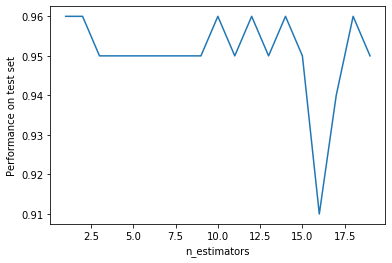

In [113]:
tree_counts = []
accuracies = []
for tree_count in range(1, 20):
    model = RandomForestClassifier(n_estimators=tree_count,
                                   max_depth=3,
                                   subset_percentage=0.5,
                                   noise_variance=0)
    model.fit(iris_train_x, iris_train_y)
    accuracy = (model.predict(iris_test_x) == iris_test_y).mean()
    accuracies.append(accuracy)
    tree_counts.append(tree_count)

print("Best performance: ", max(accuracies))
plt.xlabel('n_estimators')
plt.ylabel('Performance on test set')
plt.plot(tree_counts, accuracies)

Next, let's try adding Gaussian noise. (What happens if you set the noise variance to 0? Why?)

Best performance:  0.97


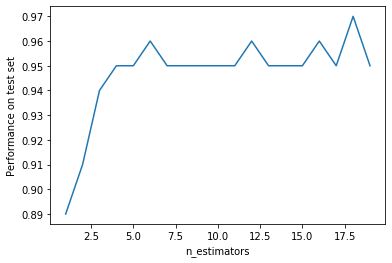

In [114]:
tree_counts = []
accuracies = []
for tree_count in range(1, 20):
    model = RandomForestClassifier(n_estimators=tree_count,
                                   max_depth=3,
                                   subset_percentage=1,
                                   noise_variance=0.1)
    model.fit(iris_train_x, iris_train_y)
    accuracy = (model.predict(iris_test_x) == iris_test_y).mean()
    accuracies.append(accuracy)
    tree_counts.append(tree_count)

print("Best performance: ", max(accuracies))
plt.xlabel('n_estimators')
plt.ylabel('Performance on test set')
plt.plot(tree_counts, accuracies)